#### Github:
https://github.com/hibbakamas/ML-fundamentals-2025.git

# Hibba Kamas Machine Learning Assignment 2

In [24]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Task 1: Exploratory Data Analysis (EDA)

In [25]:
# Load dataset
df = pd.read_csv("hour.csv")

# Show first few rows
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


#### Checking Dataset Structure

Before starting to create the model, it's important to understand the structure and contents of the dataset. I began by checking the shape of the dataset and listing the column names. This gives a quick overview of how many observations we have (17,379 rows) and how many features (17 columns), helping us understand the dataset better before continuing.

In [26]:
# basic info about the dataset
print("Dataset Shape:", df.shape)
print("\nColumn Names:\n", df.columns)

Dataset Shape: (17379, 17)

Column Names:
 Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')


#### Identifying Missing Values

Missing data can affect the model's accuracy, so it is very important to assess which features have missing values. Luckily in this case, there are no missing values

In [27]:
# Check number of missing values per column (if any)
df.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

#### Summary Statistics Observations

After gaining a general overview of the dataset, .describe() and .info() are used to view summary statistics about the dataset. Some key observations include:

- All 17 columns contain 17,379 non-null entries, which confirms there are no missing values.
- Most features are numerical, with only one object column ("dteday").
- The target variable "cnt" (total bike rentals) ranges from 1 to 977, with a mean around 189. This wide range suggests a right-skewed distribution, which may affect linear modeling.
- "temp", "atemp", "hum", and "windspeed" are normalized between 0 and 1.
- Binary features like "holiday" and "workingday" have values of 0 or 1.
- Columns like "season", "hr", "weekday", and "weathersit" are encoded as categorical integers, which we should keep in mind when making the different models.
- The "instant" column is a unique identifier and does not carry predictive value, so it will be dropped.
- The "dteday" column represents the date as a string and does not add predictive value either, so it will also be dropped.

In [28]:
# Check the structure and types of the dataset
df.info()
# Get basic statistics for numerical columns
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


### Distributions and outliers

After observing that our target variable could possibly be right-skewed, I decided to investigate further by using a histogram. The histogram confirmed that cnt is indeed right skewed, with most rental counts being quite low and then a sharp drop as the count increases.

Skewness is very important to keep in mind, especially for linear regression, which assumes the target and residuals are normally distributed. To address this, we could apply a log transformation to the target variable, to better meet the assumption of normality and linearity. 

Although decision trees and random forests are more robust to skewed data since they do not assume any underlying distribution, understanding the distribution of the target variable may help with tuning and identifying outliers and imbalances.

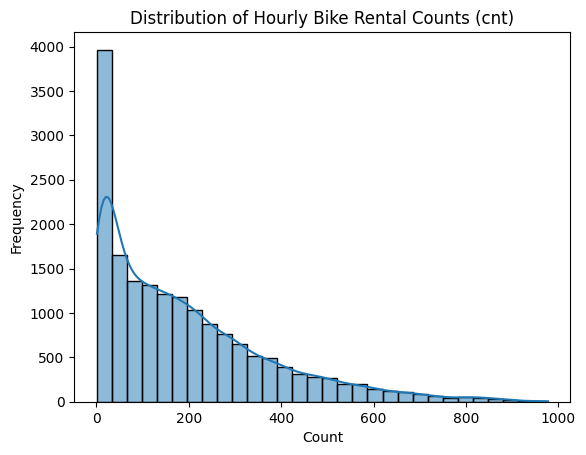

In [29]:
# Histogram of the target variable
sns.histplot(df['cnt'], bins=30, kde=True)
plt.title("Distribution of Hourly Bike Rental Counts (cnt)")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.show()


Since extreme values in numerical features can mess up the model's predictions, I decided to do a formal outlier check the target variable. Outliers can affect model's in different ways:
- In linear regression, outliers can heavily influence the fitted line which may skew results. Outlier handling methods or transformations may be necessary.
- Decision trees and random forests are more robust to outliers due to their non-linear nature. Extreme values tend to be in separate branches, minimizing their impact.

In the boxplot, we can see a large number of outliers on the higher end, more specifically beyond 600. These high values are not necessarily errors, they might just be busier times, such as rush hour. Hence, it is not for sure that they will be removed, but I can now make more informed decisions about whether to:
- Apply a log transformation in linear regression
- Leave them untouched for tree based models
- Investigate them further depending on model performance

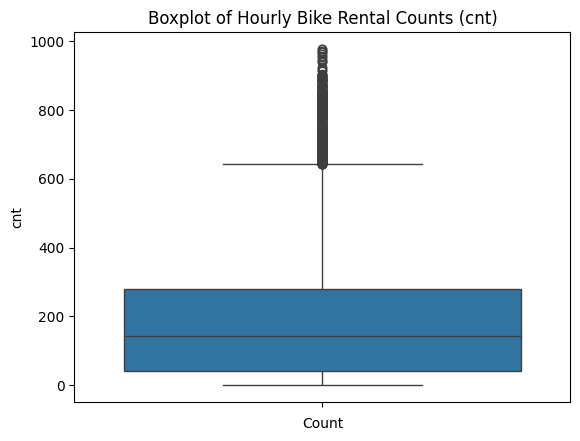

In [30]:
# Boxplot to check for outliers
sns.boxplot(y=df['cnt'])
plt.title("Boxplot of Hourly Bike Rental Counts (cnt)")
plt.xlabel("Count")
plt.show()


To better understand the behavior of the numerical input features, I visualized their distributions and boxplots. This helped identify skewness, outliers, and patterns that might impact the model.

Instead of automatically selecting numerical features using select_dtypes(), I manually selected them based on dataset knowledge. I preferred this method because sometimes, some columns are classified as numerical due to their integer values, but are actually categorical (season, yr, mnth, etc).

Some key observations include:
- Distributions:
    - temp, atemp, and hum are rougly symmetric and are fairly well distributed.
    - windspeed, casual, and registers are right skewed, with many low values and few high values. These features might need transformation, depending on the model.
    - temp and atemp look very similar, implying one might be redundant. A correlation check should be done.
    - casual and registered also seem very similar to each other, as well as to cnt. Based on dataset knowledge, I figure that cnt is the sum of casual and registered. It is important to verify this later, as if this is true it will lead to data leakage.
- Outliers:
    - Boxplots showed outliers in windspeed, casual, and registered.
    - These values are not necessarily errors, and may represent real-world scenarios such as a windy day
    - In linear regression, these outliers may mess up predictions and might require transformation, however in tree based models outliers are isolated and have less impact.

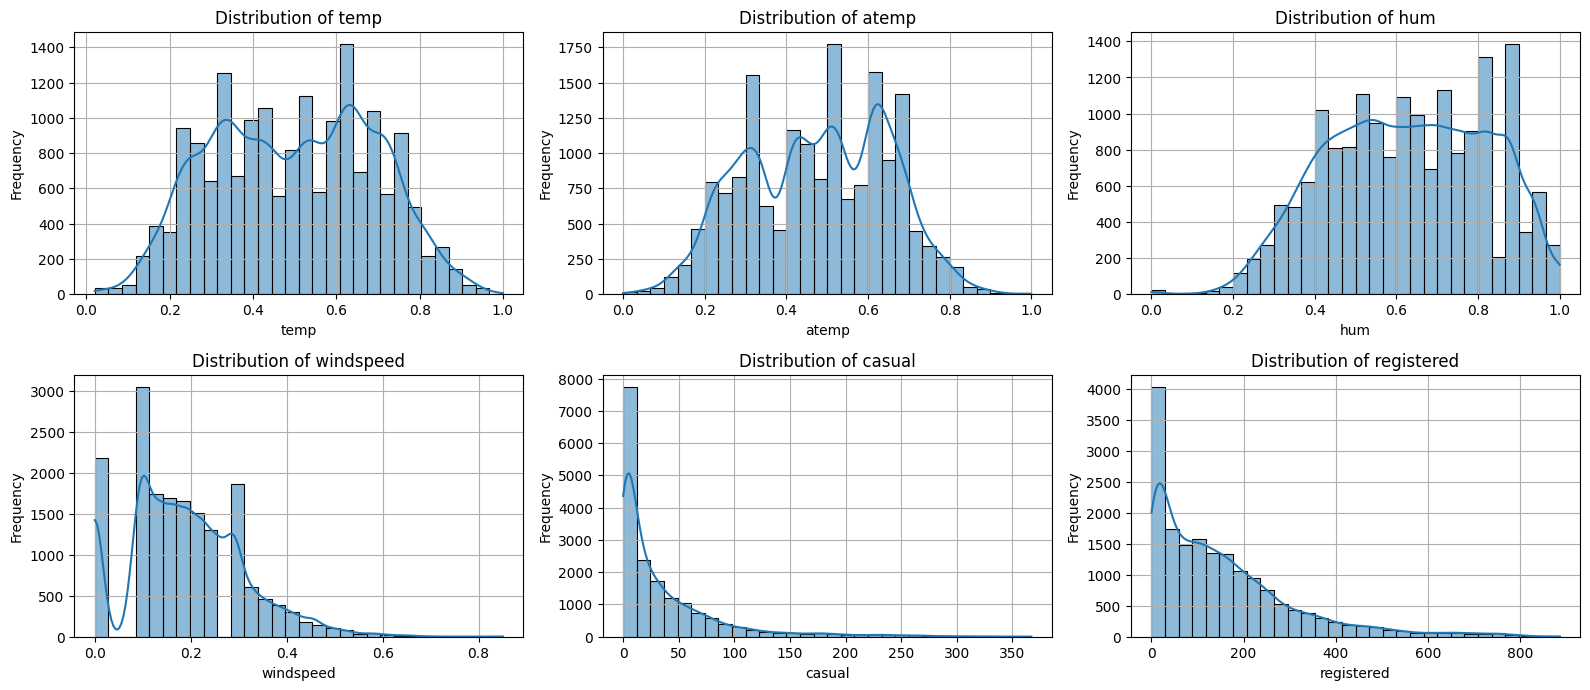

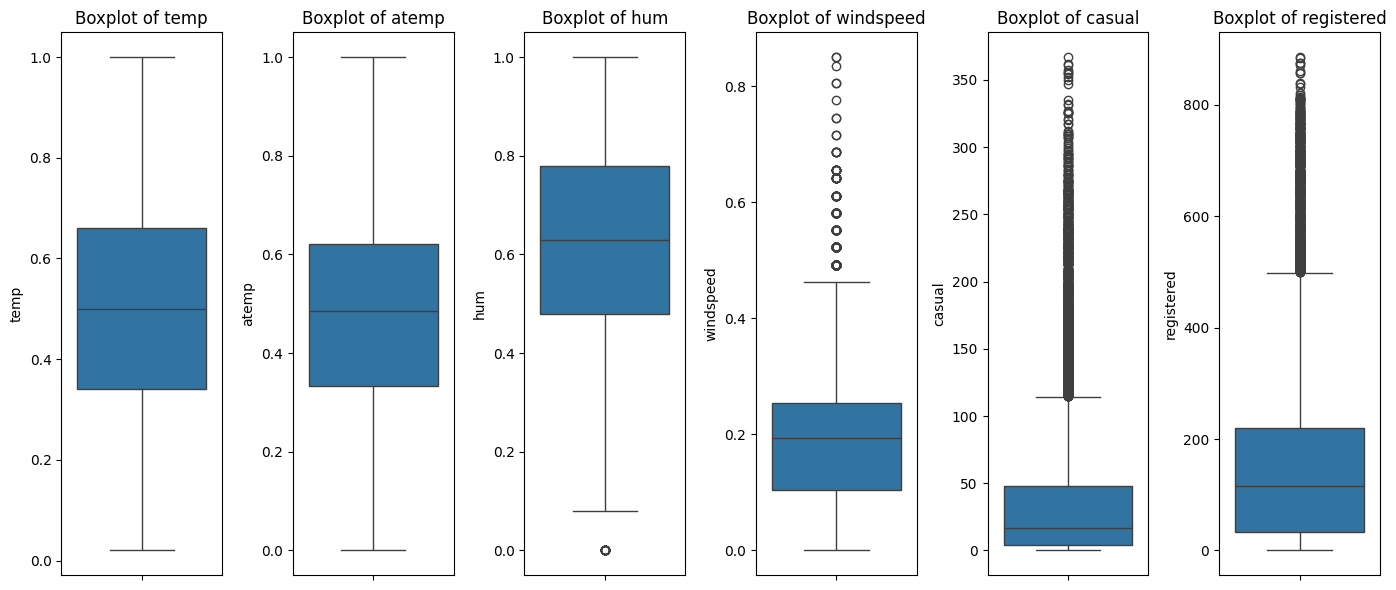

In [31]:
numerical_features = ["temp", "atemp", "hum", "windspeed", "casual", "registered"]

# distributions
plt.figure(figsize=(16, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.grid(True)
plt.tight_layout()
plt.show()

# boxplots
plt.figure(figsize=(14, 6))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, 6, i)
    sns.boxplot(y=df[feature])
    plt.title(f"Boxplot of {feature}")
plt.tight_layout()
plt.show()

Since earlier I thought that cnt could be the sum of casual and registered, I decided to confirm this with a scatter plot of casual + registered against cnt. This result showed a perfect linear relationship. To be extra thorough, I also ran a check to see if there were any mismatches between casual + registered and cnt. The mismatch count was 0, finally confirming what I originally thought.

This is a very important find, as including both features when predicting cnt would lead to data leakage, since they directly determine the target. These two columns should be dropped before modeling to ensure the model does not 'cheat'.

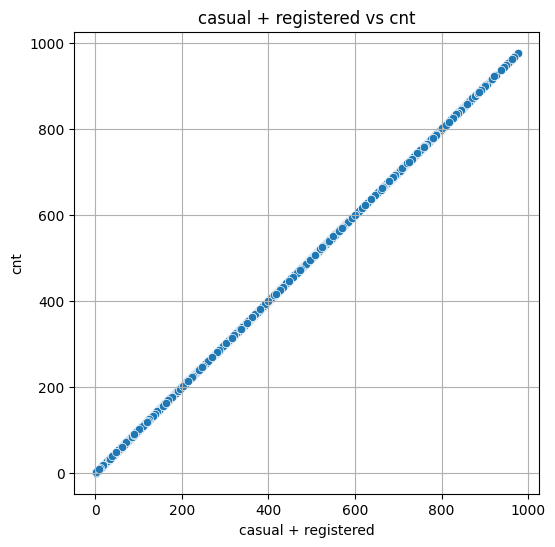

Number of mismatches: 0


In [32]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=df['casual'] + df['registered'], y=df['cnt'])
plt.title("casual + registered vs cnt")
plt.xlabel("casual + registered")
plt.ylabel("cnt")
plt.grid(True)
plt.show()

# Check if any rows break the rule: casual + registered == cnt
mismatch_count = (df['casual'] + df['registered'] != df['cnt']).sum()
print("Number of mismatches:", mismatch_count)

### Influence of temporal features
For temporal features like hr, weekday, and mnth, Line plots were used to visualize the average rental trends. Line plots work very well for ordered, time based variables because they highlight changes/patterns across a continuous timeline very clearly.


Hour:

First, I thought to explore the influence of time on bike usage. I began by checking the average number of rentals for each hour of the day, since different hours of the day (eg, rush hour) may behave differently.

From the line plot, I observed:
- From the hours of 12:00am to 6:00am, usage is at it's lowest. This makes sense considering most people are likely asleep and not commuting at this time.
- There is a sharp increase from 6:00am to 8:00am, which corresponds to common morning commute times. This suggests many people rely on bikes to get to work or school.
- From 9:00am to 4:00pm rentals decrease and remain relatively steady, but between 4:00pm and 7:00pm rentals go back up, corresponding to the time people commute home from work or school.

This hourly pattern is clearly non linear, meaning:
- Tree based models (decision trees, random forests) are well suited since they are flexible to non linearity.
- Linear models may struggle unless we apply transformations.

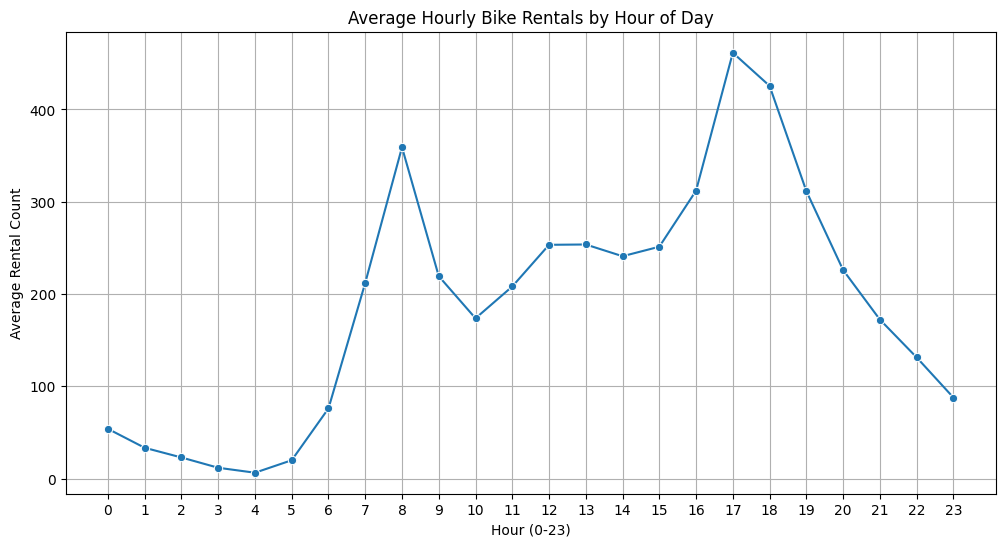

In [33]:
# Average bike rentals by hour of the day
avg_by_hour = df.groupby("hr")["cnt"].mean()

# Line plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=avg_by_hour.index, y=avg_by_hour.values, marker="o")
plt.title("Average Hourly Bike Rentals by Hour of Day")
plt.xlabel("Hour (0-23)")
plt.ylabel("Average Rental Count")
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

Weekday:

Next, I checked how different days of the week affect bike rentals, gaining a more general influence of time's influence. I plotted the average rental count per day using a line plot, since weekdays follow a natural timeline.

From the plot, I observed:
- Rentals are lowest on Sunday, then begin to increase during the week. This might suggest people stay home more often on Sundays.
- The highest usage is on Thursday and Friday, which may be due to a combination of work, errands, and social plans.
- Rentals drop slightly on Saturday, probably because people are not commuting to work/school.

Although there aren't huge differences, the pattern suggests that weekday does indeed have some influence on rentals. Its ordered nature may benefit tree-based models, however linear models might require  encoding to properly interpret it. In this case, one hot encoding may be more appropriate than ordinal encoding even though weekday is ordered, because its relationship with the target is not linear.

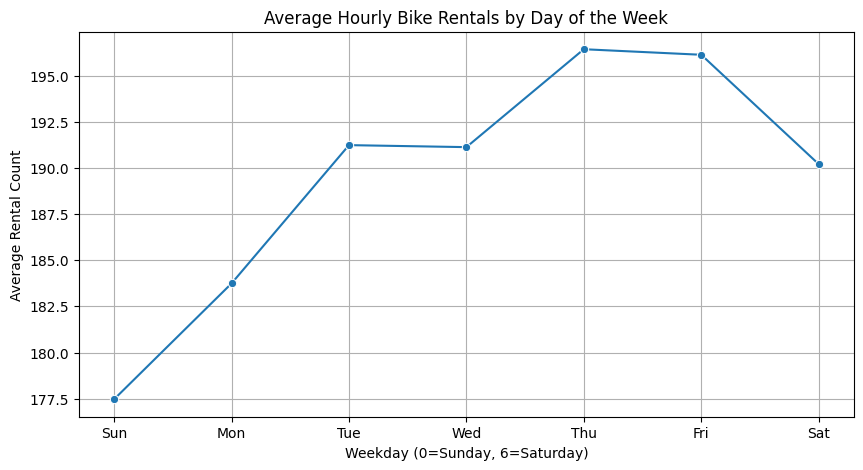

In [34]:
# Average rentals by weekday (0=Sunday, 6=Saturday)
avg_by_weekday = df.groupby("weekday")["cnt"].mean()

# Line plot
plt.figure(figsize=(10, 5))
sns.lineplot(x=avg_by_weekday.index, y=avg_by_weekday.values, marker="o")
plt.title("Average Hourly Bike Rentals by Day of the Week")
plt.xlabel("Weekday (0=Sunday, 6=Saturday)")
plt.ylabel("Average Rental Count")
plt.xticks(range(0, 7), labels=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
plt.grid(True)
plt.show()


Month:

I then visualized the influence of the month of bike rentals, gaining an even more general overview of the influence of time.

From the plot, I observed:
- Rentals continuously increase from January to June (peak), and stay high during the warmer months (June to September).
- After September, rentals begin to drop, with the lowest rentals in the coldest months (December to Febuary).
- This pattern seems to reflect seasonal weather effects, suggesting that people prefer to ride bikes in warmer, drier months,

Again, this trend is clearly non-linear, hence although tree based models do not require transformations, linear models would.

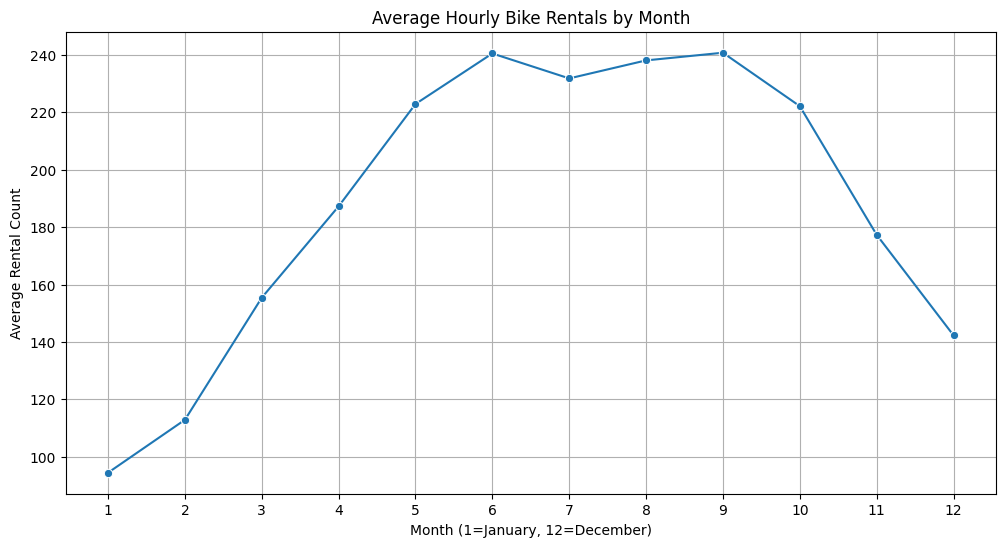

In [35]:
# Average rentals by month
avg_by_month = df.groupby("mnth")["cnt"].mean()

# Line plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=avg_by_month.index, y=avg_by_month.values, marker="o")
plt.title("Average Hourly Bike Rentals by Month")
plt.xlabel("Month (1=January, 12=December)")
plt.ylabel("Average Rental Count")
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

Season:

Finally, since the hourly bike rentals by month seemed to vary depending on the season, I visualized the average rental count using a bar plot.

From the plot, I observed:
- Rentals are lowest in Winter, implying people do not like to ride bikes in the cold.
- Rentals increase in Spring and Summer, with Summer having the highest average. This suggests warm weather encourages biking.
- In fall, rentals slightly drop, but are still relatively high.

These are the same interpretations inferred from analyzing the months of the year, implying the rental count changes in the months might be due to seasonal changes.

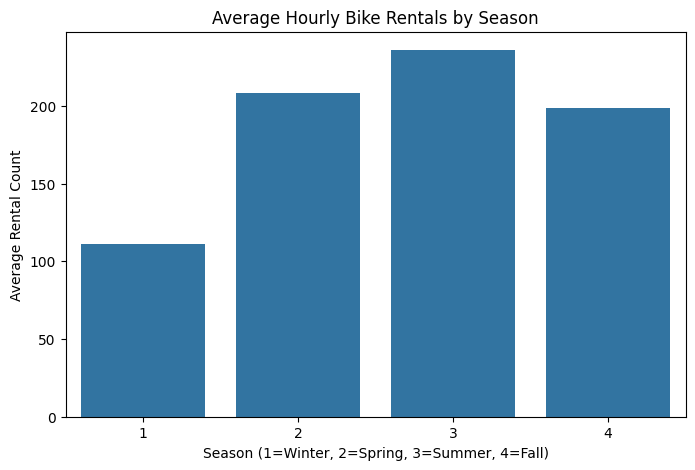

In [36]:
avg_by_season = df.groupby("season")["cnt"].mean()

plt.figure(figsize=(8, 5))
sns.barplot(x=avg_by_season.index, y=avg_by_season.values)
plt.title("Average Hourly Bike Rentals by Season")
plt.xlabel("Season (1=Winter, 2=Spring, 3=Summer, 4=Fall)")
plt.ylabel("Average Rental Count")
plt.show()

### Influence of binary features
Since these features only take two values (0 and 1), bar plots are the most intuitive and effective way to compare their impact on the target variable.

Holiday:

To check whether holidays influence bike rentals, I plotted the average rental count grouped by holiday.

From the plot, I observed:
- Rentals are higher on non holidays compared to holidays.
- The reason for this might be because people normally commute to work/school on non holidays using bikes.

Although the difference is not huge, this shows holiday does have some influence on the target variable and implies it should be kept.

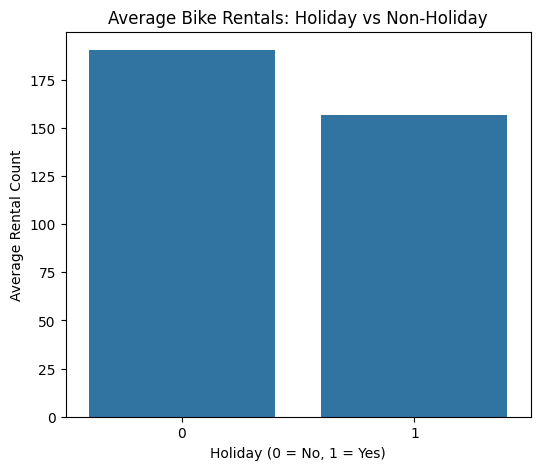

In [37]:
# Average rentals grouped by holiday
avg_by_holiday = df.groupby("holiday")["cnt"].mean()

# Bar plot
plt.figure(figsize=(6, 5))
sns.barplot(x=avg_by_holiday.index, y=avg_by_holiday.values)
plt.title("Average Bike Rentals: Holiday vs Non-Holiday")
plt.xlabel("Holiday (0 = No, 1 = Yes)")
plt.ylabel("Average Rental Count")
plt.show()

Working day:

To see how working days might affect bike rentals, I used a bar plot to compare average rental counts between working and non working days.

From the plot, I observed:
- Rentals are just slightly higher on working days.
- This makes sense and aligns with everything said previously, people rely on bikes as part of their commute to work/school.

The difference is only small, but still shows some relationship with the target variable.

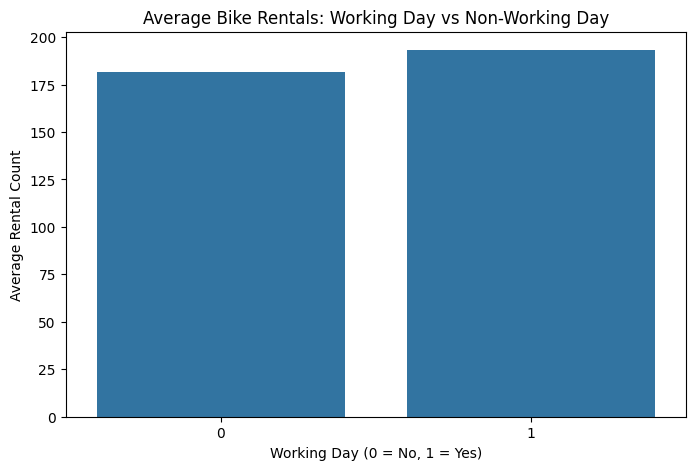

In [38]:
# Average rentals by working day
avg_by_workingday = df.groupby("workingday")["cnt"].mean()

# Bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=avg_by_workingday.index, y=avg_by_workingday.values)
plt.title("Average Bike Rentals: Working Day vs Non-Working Day")
plt.xlabel("Working Day (0 = No, 1 = Yes)")
plt.ylabel("Average Rental Count")
plt.show()

### Influence of weather related features

Line plots were used for continuous features (temp, atemp, hum, and windspeed) and bar plots for categorical ones (weathersit).

Temp:

I first felt it was important to understand how temperature influences bike usage, since it seemed to have a large impact in earlier analysis. So, I plotted the average rental count for each unique normalized temperature value using a line plot.

From the plot, I observed:
- Rentals tend to increase with temperate, which confirms our earlier hypothesis that people prefer renting bikes in warmer weather.
- The trend becomes less consistent at higher temperatures, possibly due to fewer data points at those extremes.

This relationship is more or less linear, and can be handled well with linear models and tree based models.

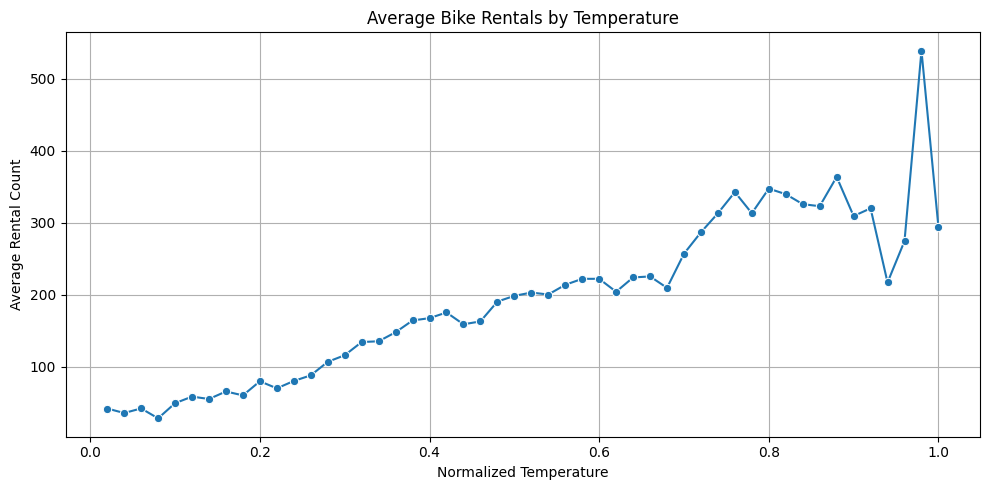

In [39]:
# Average rentals by temperature
avg_temp = df.groupby("temp")["cnt"].mean().reset_index()

# Line plot
plt.figure(figsize=(10, 5))
sns.lineplot(x="temp", y="cnt", data=avg_temp, marker="o")
plt.title("Average Bike Rentals by Temperature")
plt.xlabel("Normalized Temperature")
plt.ylabel("Average Rental Count")
plt.grid(True)
plt.tight_layout()
plt.show()

Atemp:

I also checked how the "feels like" temperature influences bike usage, since this might have more of an impact on people if it is the temperature they actually feel.

From the plot, I observed:
- Rentals increase as "feels like" temperature increases.
- The pattern is very similar to temp, implying some correlation that should be checked.

Again, the pattern is more or less linear, with the behavior closely mirroring temp. This supports the earlier assumption that one of these features might be redundant.

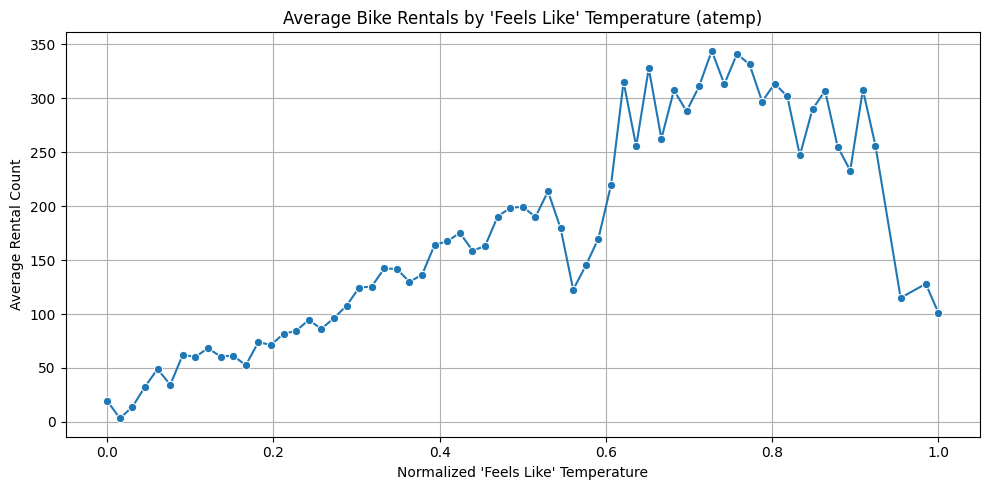

In [40]:
# Average rentals by atemp
avg_atemp = df.groupby("atemp")["cnt"].mean().reset_index()

# Line plot
plt.figure(figsize=(10, 5))
sns.lineplot(x="atemp", y="cnt", data=avg_atemp, marker="o")
plt.title("Average Bike Rentals by 'Feels Like' Temperature (atemp)")
plt.xlabel("Normalized 'Feels Like' Temperature")
plt.ylabel("Average Rental Count")
plt.grid(True)
plt.tight_layout()
plt.show()

Humidity:

Next, I analyzed how humidity might affect bike rentals rates, as humid weather tends to be less enjoyable. I used a line plot to capture this relationship.

From the plot, I observed:
- Rentals increase as humidity rises from 0 to 0.2, suggesting people do not prefer overly dry weather to ride their bikes.
- After this, rental counts decline as humidity increases, confirming my earlier assumption.

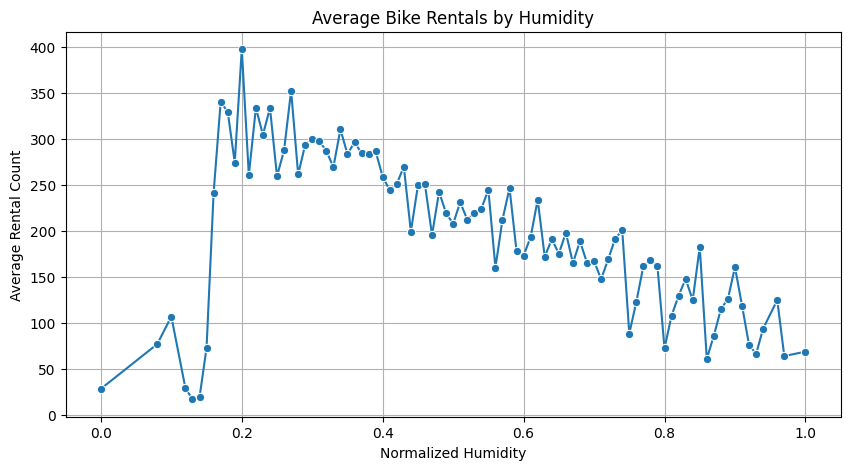

In [41]:
# Average rentals by humidity
avg_by_hum = df.groupby("hum")["cnt"].mean()

# Line plot
plt.figure(figsize=(10, 5))
sns.lineplot(x=avg_by_hum.index, y=avg_by_hum.values, marker="o")
plt.title("Average Bike Rentals by Humidity")
plt.xlabel("Normalized Humidity")
plt.ylabel("Average Rental Count")
plt.grid(True)
plt.show()

Windspeed:

I then explored how windspeed would affect bike rentals using a lineplot, as windier weather is not ideal for riding a bike.

From the plot, I observed:
- Rental counts are pretty stable across low to moderate windspeeds.
- At higher windspeeds (beyond 0.6) rental counts begin to drop, though it is difficult to tell probably due to fewer data points.

The overall influence of windspeed is very mild, but it may have a slight negative effect on rentals at higher windspeeds.

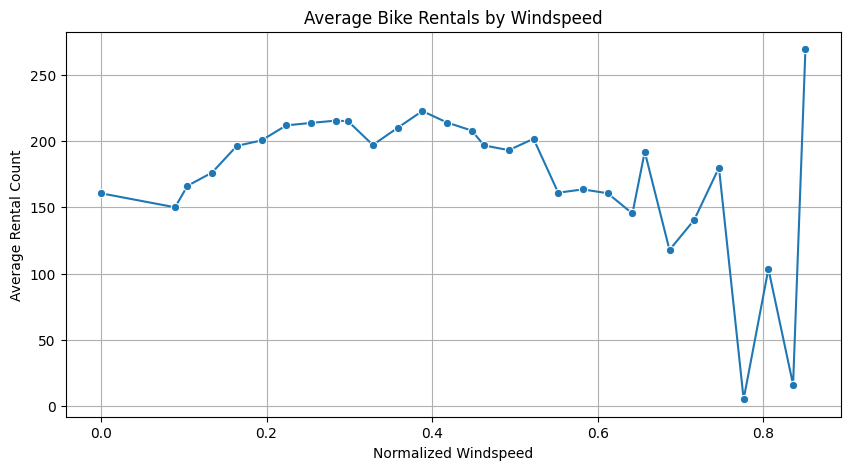

In [42]:
# Calculate average rental count by windspeed
avg_by_windspeed = df.groupby("windspeed")["cnt"].mean()

# Plotting
plt.figure(figsize=(10, 5))
sns.lineplot(x=avg_by_windspeed.index, y=avg_by_windspeed.values, marker="o")
plt.title("Average Bike Rentals by Windspeed")
plt.xlabel("Normalized Windspeed")
plt.ylabel("Average Rental Count")
plt.grid(True)
plt.show()

Weathersit:

I finally explored how different weather conditions may influence bike rentals, excluding category 4 due to its extremely low frequency which will just add noise.

From the plot, I observed:
- Rentals are highest on clear or partly cloudy days, which makes sense as the weather is ideal for biking.
- Rentals decrease on misty or cloudy days, possibly because of reduced visibility.
- Rentals experience a sharp drop when it rains or snows lightly, suggesting that bad weather discourages biking.

This analysis showed that weathersit clearly influences rental behavior, and should be kept as a feature in the model.

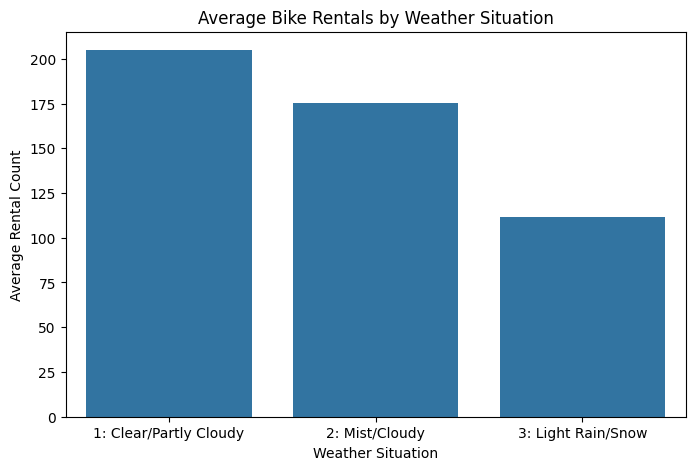

In [43]:
# Filter out rows where weathersit is 4
df_filtered = df[df["weathersit"] != 4]

# Define custom labels for valid categories
weather_labels = [
    "1: Clear/Partly Cloudy",
    "2: Mist/Cloudy",
    "3: Light Rain/Snow"
]

# Group by weather situation and calculate average rentals
avg_by_weather = df_filtered.groupby("weathersit")["cnt"].mean()

# Create bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=avg_by_weather.index, y=avg_by_weather.values)
plt.title("Average Bike Rentals by Weather Situation")
plt.xlabel("Weather Situation")
plt.ylabel("Average Rental Count")
plt.xticks(ticks=[0, 1, 2], labels=weather_labels)
plt.show()

### Correlation heatmap

Finally, the last EDA step I thought to perform was correlation analysis between the numerical features. Correlation analysis can help identify relationships and provide insights about how they interact. It can also provide important insights when it comes to feature selection, as if two features are highly correlated, one might be redundant and we can remove it and effectively reduce dimensionality. This will be very useful later, during feature selection. 

From the heatmap, I observed:

- temp and atemp have an extremely high correlation of 0.99, confirming the earlier suspicion that one is redundant.

- casual and registered are moderately correlated (0.51), and both are positively correlated with temp and atemp.

- windspeed has very low correlation with all other features, indicating it is fairly independent.

This correlation analysis supports dropping atemp due to redundancy with temp, and confirms the importance of removing casual and registered to avoid data leakage (since we earlier confirmed cnt = casual + registered).

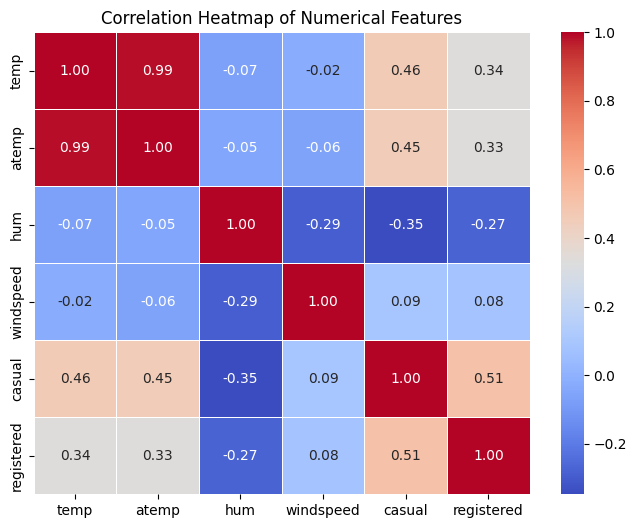

In [44]:
numerical_features = ["temp", "atemp", "hum", "windspeed", "casual", "registered"]

plt.figure(figsize=(8, 6))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

### EDA Summary
Throughout the EDA process, I made decisions with all three models in mind (linear regression, decision tree, and random forest) as each has different sensitivities and strengths: 


Linear Regression:
- Skewness and outliers in the target variable and features were checked early, since linear models are sensitive to this.

-  I checked which relationships are linear vs non linear, and noted where transformations may be necessary.

- Dropping atemp (due to high correlation with temp) helps prevent multicollinearity.

- One-hot encoding was identified as the best strategy for categorical features like weekday and season, since linear models can't handle non-numeric or ordinal features effectively.

Decision Tree:
- Trees handle non-linearity and outliers well, so I focused on identifying strong splits (e.g., sharp peaks in hr, drops in weathersit).

- No transformations are required (features like hr, temp, and hum can be used directly).

- Categorical features like season and weekday can be kept as integers because decision trees treat them as discrete values without assuming order.

Random Forest:
- Similar to decision trees, Random Forest benefits from clean, non-redundant features.

- Dropping atemp reduces noise and unnecessary complexity.

I also ensured no data leakage by dropping casual and registered, which would have otherwise led to artificially high accuracy.

Although scaling isn’t required, the removal of irrelevant or sparse features (like instant, dteday, and rare weathersit=4) helps avoid overfitting and improves generalization.

# Task 2: Data Splitting

Before performing any feature engineering or scaling, I split the dataset into training (60%), validation (20%), and test sets (20%). This is done early on, as if we scale features before splitting, the mean and standard deviation would be computed from the entire dataset, which means that test data would influence how the training data is transformed, leading to data leakage. The choice of 60 20 20 is based on the fact our dataset is relatively large, hence we can spare some data for validation and testing. This may be reconsidered during hyperparameter tuning.

To avoid leakage and preserve the natural timeline of the data, I began by sorting the data by the date and hour, although it might have already been sorted, as an extra precaution. I did not shuffle the data and use the regular train_test_split function, as this would randomly split the dataset, and maintaining temporal order is crucial when it comes to time sensitive data. Then, I calculated the index positions of the training and validation sets and used array slicing to split the dataset into three sequential parts. After a quick verification of the split sizes, I separated the features (X) and the target variable cnt (Y) for each set.

This way, we ensure a realistic model that mimics real-world scenarios and data leakage is avoided by ensuring the model is trained on earlier data and evaluated on future data.

Although tools like TimeSeriesSplit (skikit-learn) and temporal_train_test_split (sktime) exist for splitting time based data, I chose not to use them for this task for the following reasons:
1. TimeSeriesSplit is designed for time series cross validation, and hence creates folds rather than fixed 60/20/20 splits. To control exact percentages, it would need additional customization and unnecessary complexity.
2. temporal_train_test_split is designed for time series forecasting problems. However, our dataset is tabular data with a time component, and the goal is not to forecase future time steps.

In the end, I decided my manual approach was more appropriate, simpler, and still preserves the timeline of the data.

In [45]:
# Sort by date and time if not already sorted
df = df.sort_values(by=['dteday', 'hr'])

# Calculate split indices
n = len(df)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

# Split the data
train_df = df[:train_end]
val_df = df[train_end:val_end]
test_df = df[val_end:]

# Verify the split sizes
print(f"Training set size: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation set size: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test set size: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

# Separate features and target
X_train = train_df.drop('cnt', axis=1)
y_train = train_df['cnt']

X_val = val_df.drop('cnt', axis=1)
y_val = val_df['cnt']

X_test = test_df.drop('cnt', axis=1)
y_test = test_df['cnt']

Training set size: 10427 (60.0%)
Validation set size: 3476 (20.0%)
Test set size: 3476 (20.0%)
